<h1>Literary Pulse: Navigating Kindle Sentiments with Recurrent Pages</h1>
<h3>Lab Seven: Recurrent Network Architectures</h3>

Emily Liss

<H2>Business Understanding</H2>

The dataset is a subset of book reviews from the Amazon Kindle Store, collected over a span of nearly two decades. The primary purpose of collecting this data is likely to analyze and understand customer sentiments and opinions regarding Kindle books. The dataset provides an opportunity to explore various aspects, such as how people rate and review Kindle books, factors influencing the helpfulness of a review, detecting fake reviews or outliers, and identifying best-rated products or similarities between products based on reviews. The reviewers rate the book on a scale of 1-5. Here I will be training a binary classifier where a review with a rating of 3 or below is bad and a rating of 4 or above is good. 

Several third parties may find the results of your analysis and prediction task useful: Amazon Kindle Store might be interested in understanding customer sentiments to improve their products and services and detecting fake reviews is crucial for maintaining the integrity of their review system; publishers and authors could benefit from insights into what aspects of books are positively or negatively received. Luckily, there is no serious danger of a false positive or negative, so the threshold for useful performance doesn't need to be very high.

Dataset Source: https://www.kaggle.com/datasets/meetnagadia/amazon-kindle-book-review-for-sentiment-analysis/

<H2>Load Data</H2>

In [1]:
import pandas as pd

# Read in the dataset
ds = pd.read_csv('./all_kindle_review.csv')

# remove unneeded collums
ds = ds.dropna()
print(ds.columns)
ds = ds.drop(columns=['ID', 'Unnamed: 0', 'asin', 'reviewTime', 'reviewerID', 'reviewerName', 'unixReviewTime'])
print(ds.columns)
ds.describe()

Index(['ID', 'Unnamed: 0', 'asin', 'helpful', 'rating', 'reviewText',
       'reviewTime', 'reviewerID', 'reviewerName', 'summary',
       'unixReviewTime'],
      dtype='object')
Index(['helpful', 'rating', 'reviewText', 'summary'], dtype='object')


,rating
count,11962.000000
mean,3.250209
std,1.421235
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


This is a great dataset as it's very balenced, having 2000 1 star reviews, 2000 2 star, 2000 3 star, 3000 4 star, and 3000 5 star reviews. Well balenced and a good spread of reviews. Since I'm making a binary classifier, ratings of 3 and under will be considered "bad" and represented by a 0 and ratings 4 and up will be considered "good" and represented by a 1. This gives me 6000 reviews in both catagories. 

<h2>Prepare Data</h2>
Since the data is very well balenced, I didn't feel the need to do anything fancy to split the data into a training and testing set. I did a very simple 80/20 split  

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert ratings to binary sentiment (1 for positive, 0 for negative)
ds['sentiment'] = np.where(ds['rating'] >= 4, 1, 0)

# Combine 'summary' and 'reviewText' into a single input
ds['review'] = ds['summary'] + ' ' + ds['reviewText']

#CHANGE THIS LATER

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ds['review'], ds['sentiment'], test_size=0.2, random_state=42)

ds['review_length'] = ds['review'].apply(lambda x: len(x.split()))
max_words = ds.loc[ds['review_length'].idxmax(), 'review_length']
ave_words = int(ds['review_length'].mean())

# Tokenization
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Padding sequences
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=ave_words)
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=ave_words)


<h2>Models</h2>

The GloVe pre-trained embeddings come in several sizes: 50d, 100d, 200d, and 300d. I played around with them and found that 200 worked well, the vibes were there. 

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

# Model 1: Simple RNN
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=max_words, output_dim=100, input_length=ave_words))
model_rnn.add(SimpleRNN(50))
model_rnn.add(Dense(1, activation='sigmoid'))
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])


# Model 2: LSTM
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_words, output_dim=100, input_length=ave_words))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

# Model 3: Glove Embedding Layer
embedding_dim = 200
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
with open('./glove.6B.200d.txt', encoding='utf-8') as f:
    for line in f:
        word, *vector = line.split()
        if word in tokenizer.word_index:
            idx = tokenizer.word_index[word]
            embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
model_gru = Sequential()
model_gru.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=ave_words, weights=[embedding_matrix], trainable=False))
model_gru.add(GRU(128, dropout=0.3))
model_gru.add(Dense(1, activation='sigmoid'))
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

# Model 4: Bidirectional LSTM-GRU
model_bidirectional = Sequential()
model_bidirectional.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=ave_words, weights=[embedding_matrix], trainable=False))
model_bidirectional.add(Bidirectional(LSTM(64, return_sequences=True)))
model_bidirectional.add(Bidirectional(GRU(64)))
model_bidirectional.add(Dense(1, activation='sigmoid'))
model_bidirectional.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

models = [model_rnn, model_lstm, model_gru, model_bidirectional]


<h2>Run Models</h2>
I ran this with different numbers of epochs, at 10 models 2, 3 and 4 didn't converge, then I tried 50 epochs and the models started behaving strange around 40 epochs, they each seem to even out around 30 epochs

In [5]:
histories = []
for i, model in enumerate(models):
    print(f'Model {i+1}')
    histories.append(model.fit(X_train_pad, y_train, epochs=30, batch_size=64, validation_split=0.2))

Model 1
Epoch 1/30
120/120 [==============================] - 5s 32ms/step - loss: 0.5946 - accuracy: 0.6743 - precision: 0.6760 - recall: 0.6751 - auc: 0.7484 - val_loss: 0.4814 - val_accuracy: 0.7764 - val_precision: 0.7828 - val_recall: 0.7715 - val_auc: 0.8540
Epoch 2/30
120/120 [==============================] - 4s 32ms/step - loss: 0.3877 - accuracy: 0.8294 - precision: 0.8286 - recall: 0.8325 - auc: 0.9102 - val_loss: 0.4573 - val_accuracy: 0.7915 - val_precision: 0.7790 - val_recall: 0.8201 - val_auc: 0.8693
Epoch 3/30
120/120 [==============================] - 4s 34ms/step - loss: 0.2443 - accuracy: 0.9083 - precision: 0.9047 - recall: 0.9136 - auc: 0.9663 - val_loss: 0.4692 - val_accuracy: 0.8124 - val_precision: 0.8255 - val_recall: 0.7973 - val_auc: 0.8781
Epoch 4/30
120/120 [==============================] - 3s 29ms/step - loss: 0.1026 - accuracy: 0.9676 - precision: 0.9639 - recall: 0.9719 - auc: 0.9948 - val_loss: 0.5855 - val_accuracy: 0.7879 - val_precision: 0.7747 - v

<h3>How'd They Do?</h3>

In [6]:
from sklearn import metrics as mt
for i, model in enumerate(models):
    print(f"Model {i+1}")
    yhat = np.round(model.predict(X_test_pad))
    print(mt.classification_report(y_test,yhat))

Model 1
75/75 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1224
           1       0.79      0.81      0.80      1169

    accuracy                           0.80      2393
   macro avg       0.80      0.80      0.80      2393
weighted avg       0.80      0.80      0.80      2393

Model 2
75/75 [==============================] - 2s 21ms/step
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      1224
           1       0.78      0.77      0.77      1169

    accuracy                           0.78      2393
   macro avg       0.78      0.78      0.78      2393
weighted avg       0.78      0.78      0.78      2393

Model 3
75/75 [==============================] - 4s 41ms/step
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1224
           1       0.83      0.86      0.85      116

<h2>Let's Look at the Models Separately</h2>

To evaluate the performance of a binary classification setting, the choice of metrics should go beyond accuracy due to potential imbalances in the class distribution. In this context, precision, recall, and AUC score become significant. Precision calculates the ratio of correctly predicted positive observations to the total predicted positive observations, recall computes the ratio of correctly predicted positive observations to the all observations in actual class, while AUC score shows the true positive to false positive ratio. So we'll be looking at all of these metrics to evaluate the model.

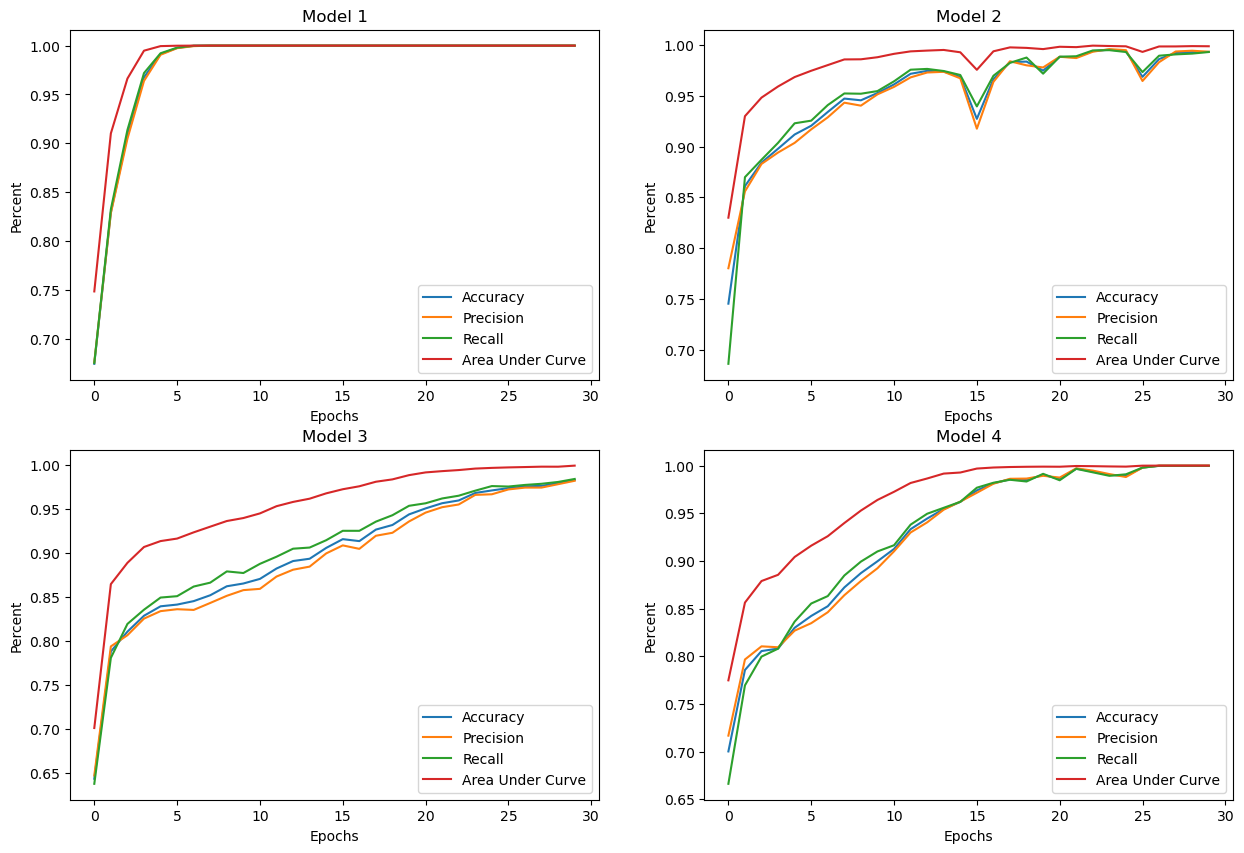

In [7]:
from matplotlib import pyplot as plt
values = [[] for _ in range(4)]
for i in range(4):
    values[i] = histories[i].history['accuracy'], histories[i].history['precision'], histories[i].history['recall'], histories[i].history['auc'], histories[i].history['loss']

plt.figure(figsize=(15, 10))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(values[i][0], label='Accuracy')
    plt.plot(values[i][1], label='Precision')
    plt.plot(values[i][2], label='Recall')
    plt.plot(values[i][3], label='Area Under Curve')
    plt.title(f'Model {i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Percent')
    plt.legend()

Something wonky is happening at the 15th and 25th epoch, but overall, the models perform quite consistantly over every metric. I'd say model 1 is the best, it trains the quickest and has been the most consistant. 

<h2>Loss Convergence</h2>

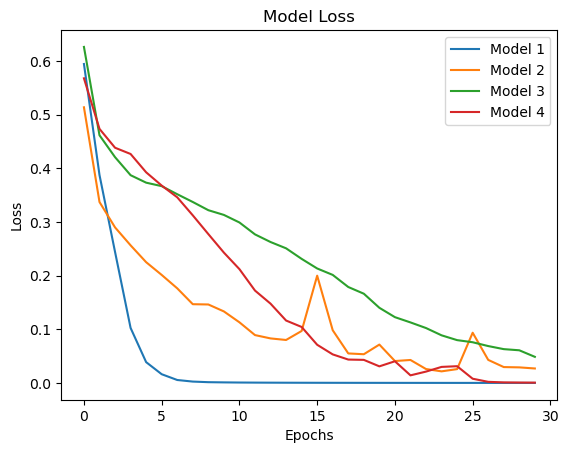

In [8]:
for i in range(4):
    plt.plot(values[i][4], label=f'Model {i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

Like I said, somthing weird at the 15th and 25th epoch for model 2, but overall they converge. Models 3 & 4 converge better with more epochs but models 1 & 2 start to overfit and the metrics get spazzy

<h2>Model Comparison</h2>

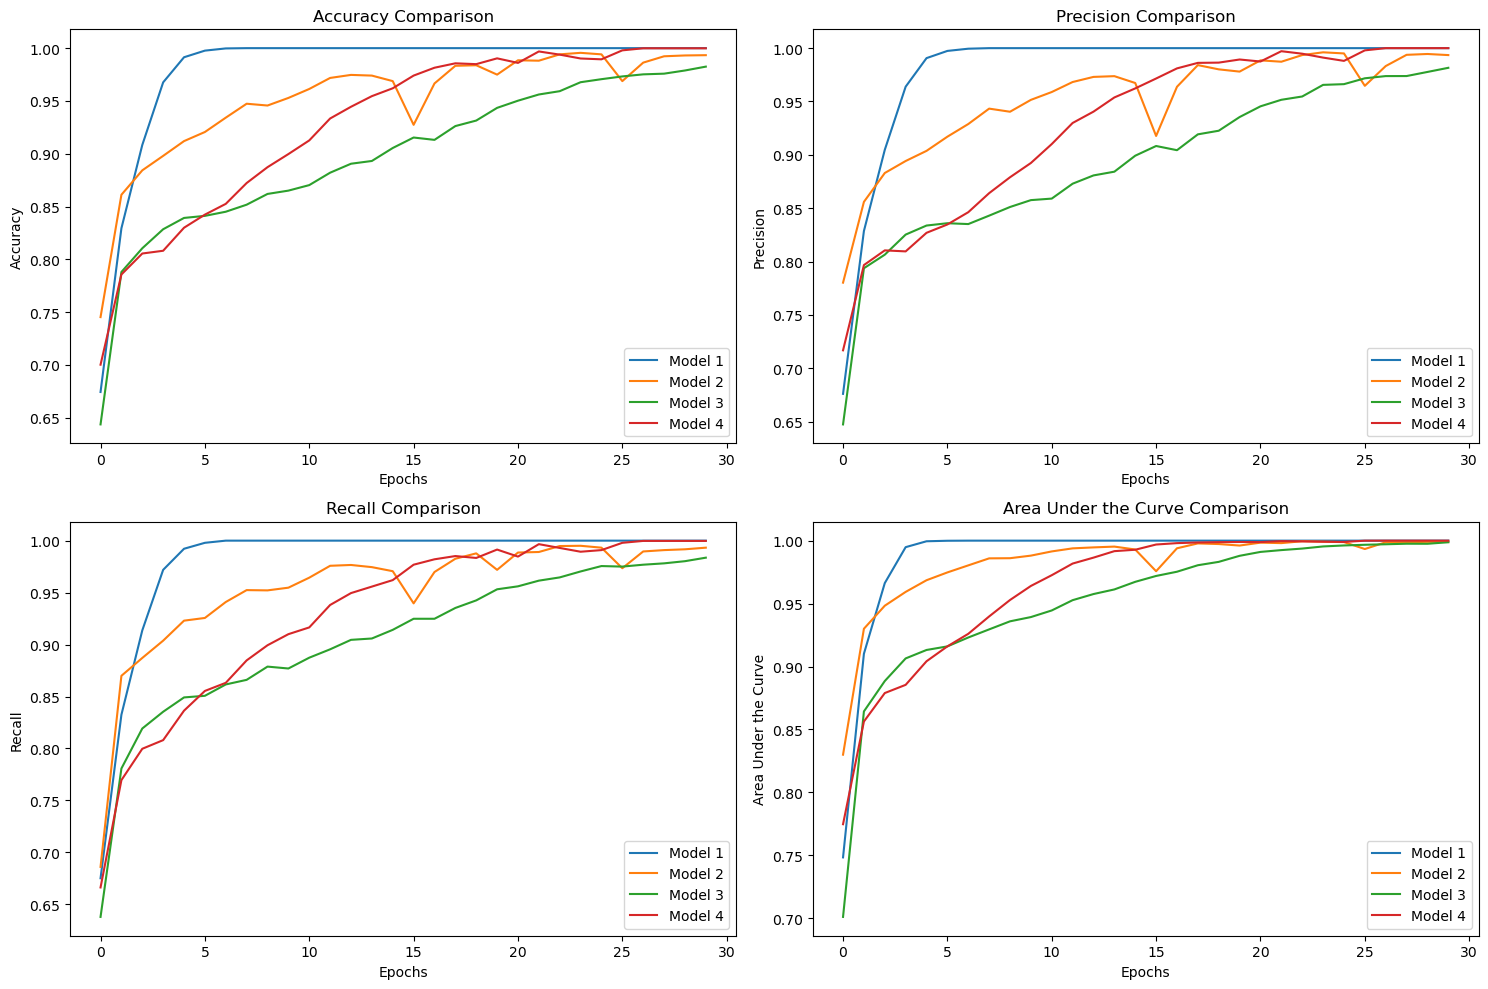

In [9]:
metrics = ['Accuracy', 'Precision', 'Recall', 'Area Under the Curve']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    plt.plot(values[0][i], label='Model 1')
    plt.plot(values[1][i], label='Model 2')
    plt.plot(values[2][i], label='Model 3')
    plt.plot(values[3][i], label='Model 4')
    plt.title(f'{metric} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

<h2>And if You Don't Love me Now, You Will Never Love me Again, I can Still Hear You Saying
You Would Never Break the Chain</h2>
Because we're adding another one! (I'm going crazy from finals, let me have my fun)

In [48]:
# RNN with Two Recurrent Chains
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=max_words, output_dim=100, input_length=ave_words))
model_rnn.add(SimpleRNN(50, return_sequences=True))  # Add return_sequences=True 
model_rnn.add(SimpleRNN(50))  # This is the second recurrent chain
model_rnn.add(Dense(1, activation='sigmoid'))
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

print("Model 1")
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=ave_words)
histories[4] = (model_rnn.fit(X_train_pad, y_train, epochs=30, batch_size=64, validation_split=0.2))

Model 1
Epoch 1/30
120/120 [==============================] - 18s 94ms/step - loss: 0.6312 - accuracy: 0.6162 - precision: 0.6216 - recall: 0.6025 - auc: 0.6814 - val_loss: 0.4898 - val_accuracy: 0.7717 - val_precision: 0.7998 - val_recall: 0.7311 - val_auc: 0.8464
Epoch 2/30
120/120 [==============================] - 11s 89ms/step - loss: 0.3820 - accuracy: 0.8332 - precision: 0.8359 - recall: 0.8309 - auc: 0.9100 - val_loss: 0.4770 - val_accuracy: 0.7905 - val_precision: 0.8223 - val_recall: 0.7466 - val_auc: 0.8639
Epoch 3/30
120/120 [==============================] - 11s 88ms/step - loss: 0.1933 - accuracy: 0.9274 - precision: 0.9310 - recall: 0.9238 - auc: 0.9776 - val_loss: 0.6187 - val_accuracy: 0.7456 - val_precision: 0.7703 - val_recall: 0.7073 - val_auc: 0.8157
Epoch 4/30
120/120 [==============================] - 11s 90ms/step - loss: 0.0655 - accuracy: 0.9795 - precision: 0.9805 - recall: 0.9787 - auc: 0.9971 - val_loss: 0.7581 - val_accuracy: 0.7926 - val_precision: 0.7800

<h2>Loss Convergence</h2>

Text(0.5, 1.0, 'Model Loss')

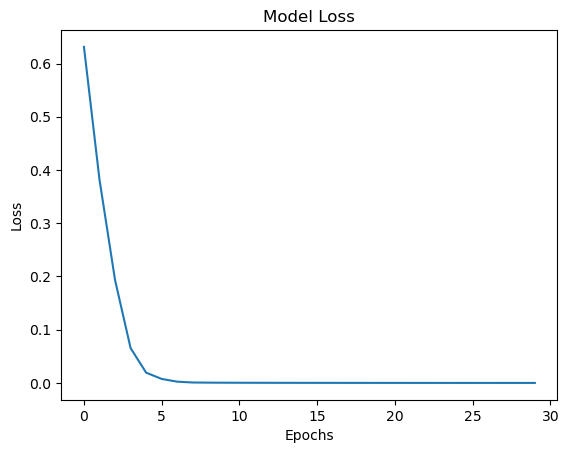

In [50]:
values[4] = histories[4].history['accuracy'], histories[4].history['precision'], histories[4].history['recall'], histories[4].history['auc'], histories[4].history['loss']
plt.plot(values[4][4])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

It converges!

<h2>Model 1 With a Single Chain VS Model 1 With Two Chains</h2>

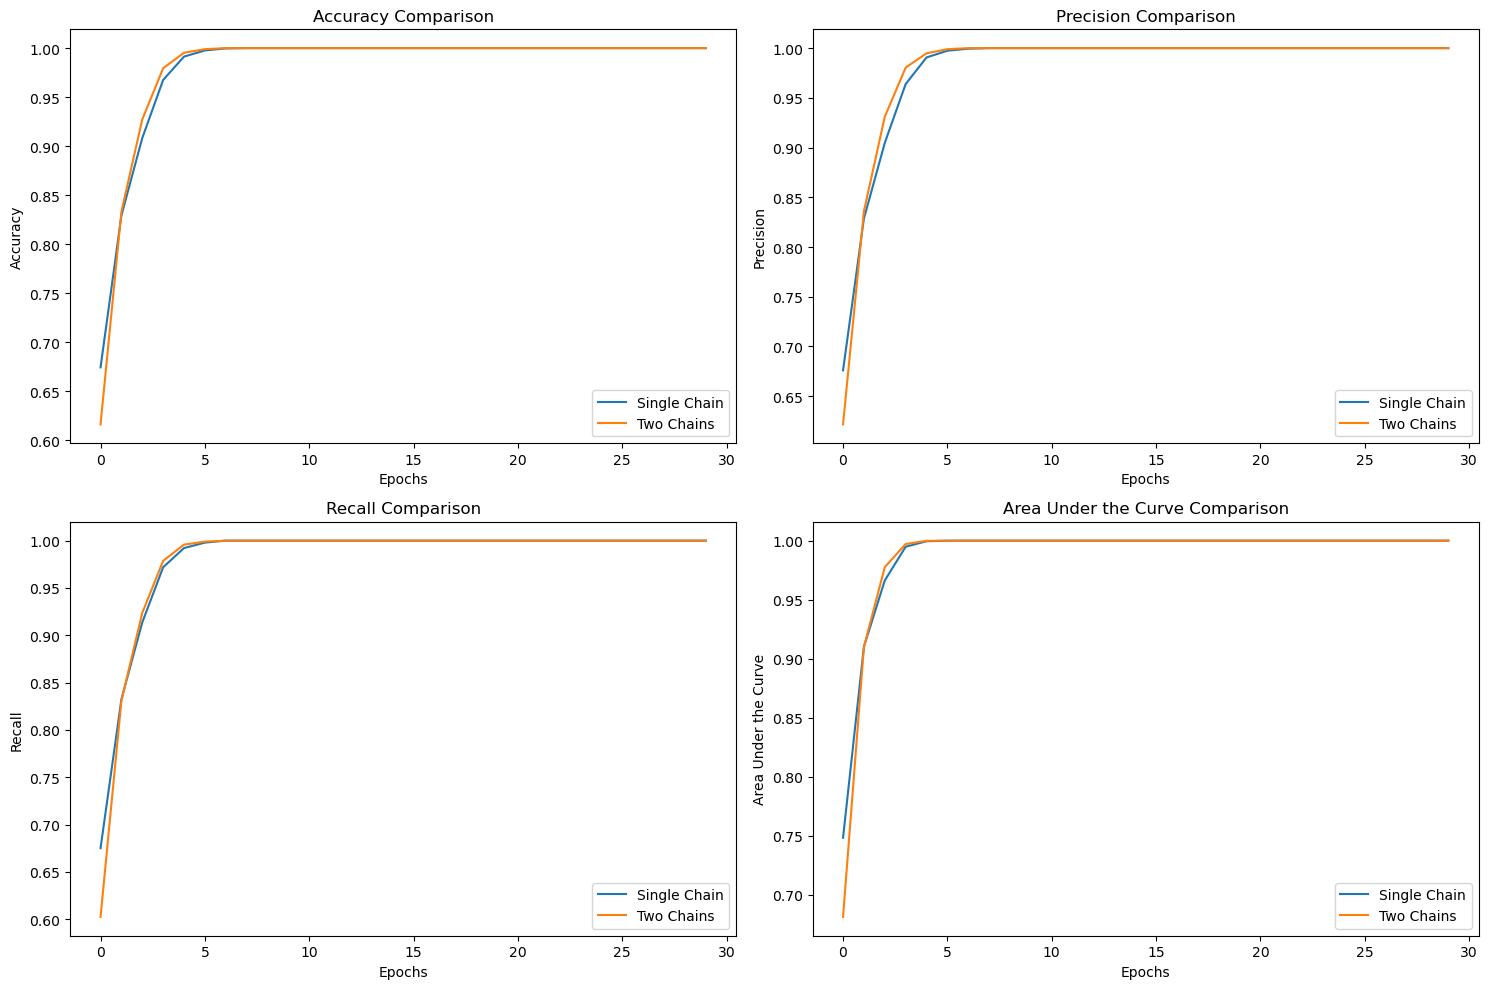

In [51]:
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    plt.plot(values[0][i], label='Single Chain')
    plt.plot(values[4][i], label='Two Chains')
    plt.title(f'{metric} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

Overall, not much of a difference

<h2>New Model 1 Compared to the Other Models</h2>

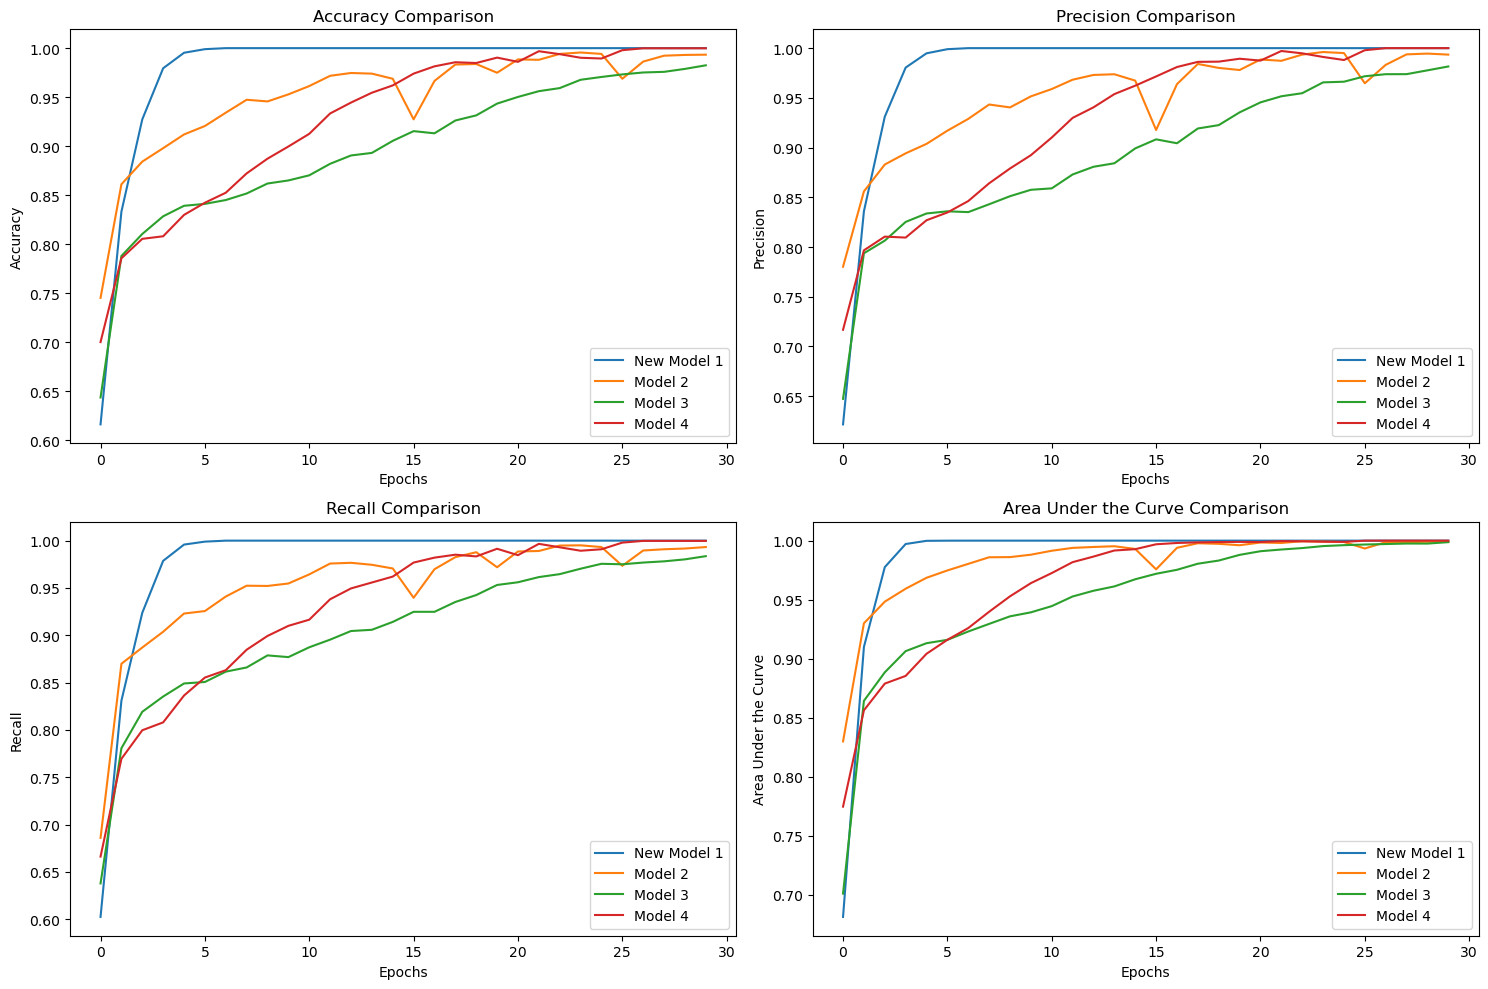

In [52]:
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    plt.plot(values[4][i], label='New Model 1')
    plt.plot(values[1][i], label='Model 2')
    plt.plot(values[2][i], label='Model 3')
    plt.plot(values[3][i], label='Model 4')
    plt.title(f'{metric} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

<h2>Generate Book Reviews</h2>

In [56]:
total_words = len(tokenizer.word_index) + 1

# Create input sequences
input_sequences = []
for review in ds['review']:
    token_list = tokenizer.texts_to_sequences([review])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_length = max([len(seq) for seq in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')

X, y = input_sequences[:, :-1], input_sequences[:, -1]
y = tf.keras.utils.to_categorical(y, num_classes=max_words)

# Build the LSTM-based text generation model
model = Sequential()
model.add(Embedding(max_words, 100, input_length=max_sequence_length-1))
model.add(LSTM(150, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(max_words, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

In [ ]:
model.fit(X, y, epochs=5, verbose=1)
print("Done")

In [ ]:
seed_text = "This book"
for _ in range(50):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
    predicted_probs = model.predict(token_list, verbose=0)[0]
        
    # Sample the next word based on predicted probabilities
    predicted_index = np.random.choice(len(predicted_probs), p=predicted_probs)
        
    output_word = ""
    for word, index in tokenizer.word_index.items():
        
        if index == predicted_index:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

<h2>Preprocessed Data</h2>

This dataset also came with a preprocessed set of the same data, let's see it and compare the results.

In [10]:
# Read in the dataset
dsp = pd.read_csv('./preprocessed_kindle_review.csv')

# remove unneeded collums
dsp = dsp.dropna()
print(dsp.columns)
dsp.describe()

# Convert ratings to binary sentiment (1 for positive, 0 for negative)
dsp['sentiment'] = np.where(dsp['rating'] >= 4, 1, 0)

# Combine 'summary' and 'reviewText' into a single input
dsp['review'] = dsp['summary'] + ' ' + dsp['reviewText']

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_trainP, X_testP, y_trainP, y_testP = train_test_split(dsp['review'], dsp['sentiment'], test_size=0.2, random_state=42)

dsp['review_length'] = dsp['review'].apply(lambda x: len(x.split()))
max_words = dsp.loc[dsp['review_length'].idxmax(), 'review_length']
ave_words = int(dsp['review_length'].mean())

# Tokenization
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_trainP)

# Padding sequences
X_trainP_pad = pad_sequences(tokenizer.texts_to_sequences(X_trainP), maxlen=ave_words)
X_testP_pad = pad_sequences(tokenizer.texts_to_sequences(X_testP), maxlen=ave_words)

Index(['Unnamed: 0', 'rating', 'reviewText', 'summary'], dtype='object')


<h2>Run the Models with the Preprocessed Data</h2>

In [11]:
historiesP = []
for i, model in enumerate(models):
    print(f'Model {i+1}')
    historiesP.append(model.fit(X_trainP_pad, y_trainP, epochs=30, batch_size=64, validation_split=0.2))

Model 1
Epoch 1/30
120/120 [==============================] - 4s 37ms/step - loss: 0.9031 - accuracy: 0.5626 - precision: 0.5672 - recall: 0.5447 - auc: 0.5782 - val_loss: 0.6683 - val_accuracy: 0.5917 - val_precision: 0.5855 - val_recall: 0.6101 - val_auc: 0.6261
Epoch 2/30
120/120 [==============================] - 4s 36ms/step - loss: 0.5976 - accuracy: 0.6802 - precision: 0.6831 - recall: 0.6775 - auc: 0.7468 - val_loss: 0.6521 - val_accuracy: 0.6161 - val_precision: 0.6215 - val_recall: 0.5818 - val_auc: 0.6632
Epoch 3/30
120/120 [==============================] - 5s 38ms/step - loss: 0.5518 - accuracy: 0.7197 - precision: 0.7325 - recall: 0.6959 - auc: 0.7954 - val_loss: 0.6349 - val_accuracy: 0.6391 - val_precision: 0.6283 - val_recall: 0.6698 - val_auc: 0.6977
Epoch 4/30
120/120 [==============================] - 5s 41ms/step - loss: 0.4967 - accuracy: 0.7604 - precision: 0.7585 - recall: 0.7672 - auc: 0.8425 - val_loss: 0.6363 - val_accuracy: 0.6589 - val_precision: 0.6606 - v

<h2>How'd They Do?</h2>

In [12]:
for i, model in enumerate(models):
    print(f"Model {i+1}")
    yhat = np.round(model.predict(X_testP_pad))
    print(mt.classification_report(y_testP,yhat))

Model 1
75/75 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      1211
           1       0.75      0.69      0.72      1189

    accuracy                           0.73      2400
   macro avg       0.73      0.73      0.73      2400
weighted avg       0.73      0.73      0.73      2400

Model 2
75/75 [==============================] - 3s 44ms/step
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1211
           1       0.79      0.78      0.79      1189

    accuracy                           0.79      2400
   macro avg       0.79      0.79      0.79      2400
weighted avg       0.79      0.79      0.79      2400

Model 3
75/75 [==============================] - 4s 51ms/step
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1211
           1       0.83      0.79      0.81      11

<h2>Individual Models</h2>

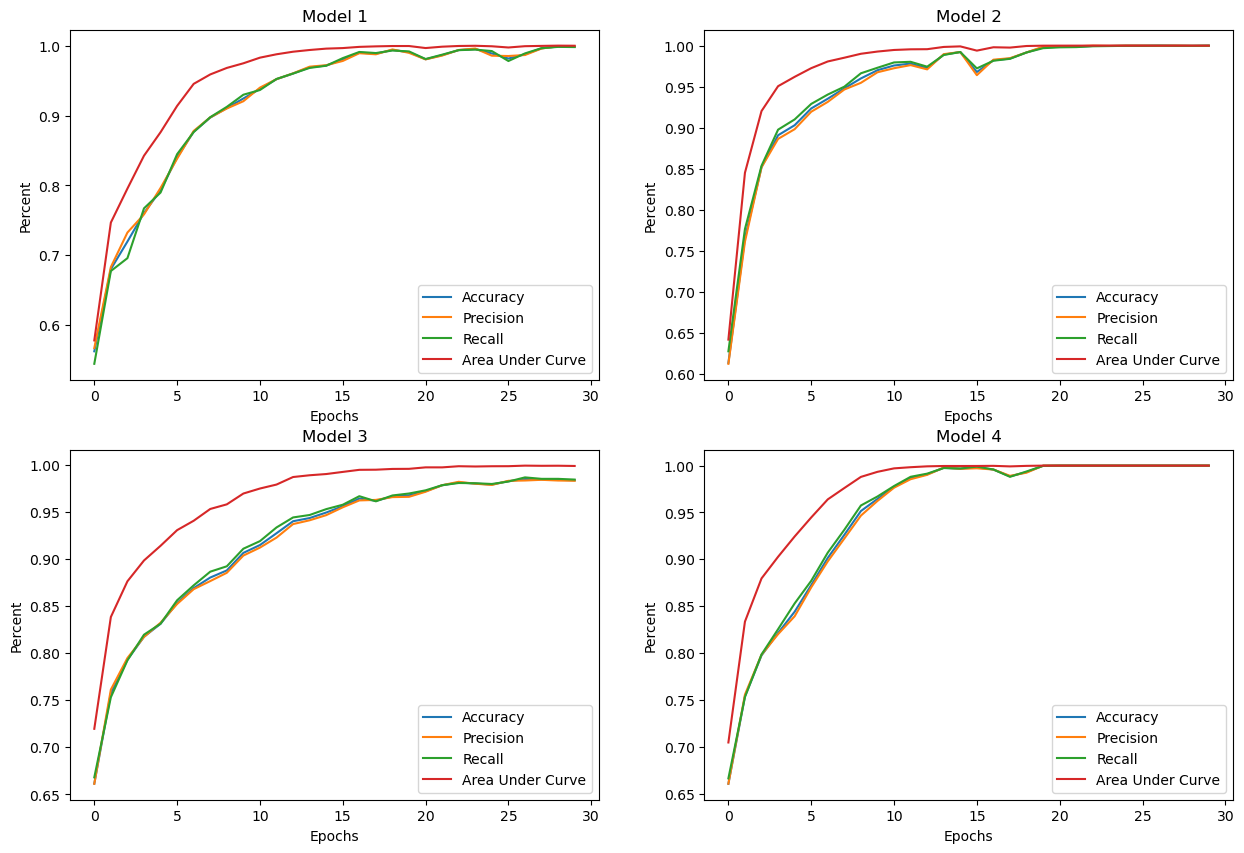

In [13]:
valuesP = [[] for _ in range(4)]
for i in range(4):
    valuesP[i] = historiesP[i].history['accuracy'], historiesP[i].history['precision'], historiesP[i].history['recall'], historiesP[i].history['auc'], historiesP[i].history['loss']

plt.figure(figsize=(15, 10))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(valuesP[i][0], label='Accuracy')
    plt.plot(valuesP[i][1], label='Precision')
    plt.plot(valuesP[i][2], label='Recall')
    plt.plot(valuesP[i][3], label='Area Under Curve')
    plt.title(f'Model {i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Percent')
    plt.legend()

These models are also very consistant, but it still seems that something strange is still happening at the 15th epoch for model 2. Model 4 seems to plateu the best with the best metric results

<h2>Loss Convergence</h2>

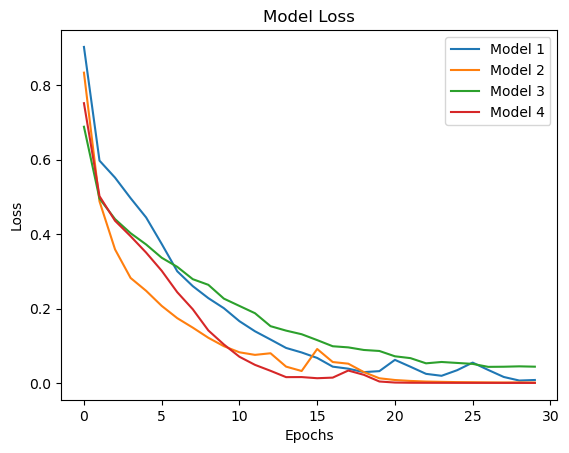

In [14]:
for i in range(4):
    plt.plot(valuesP[i][4], label=f'Model {i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

The preprocessed data seems to converge better than the normal data

<h2>With and Without Preprocessing</h2>

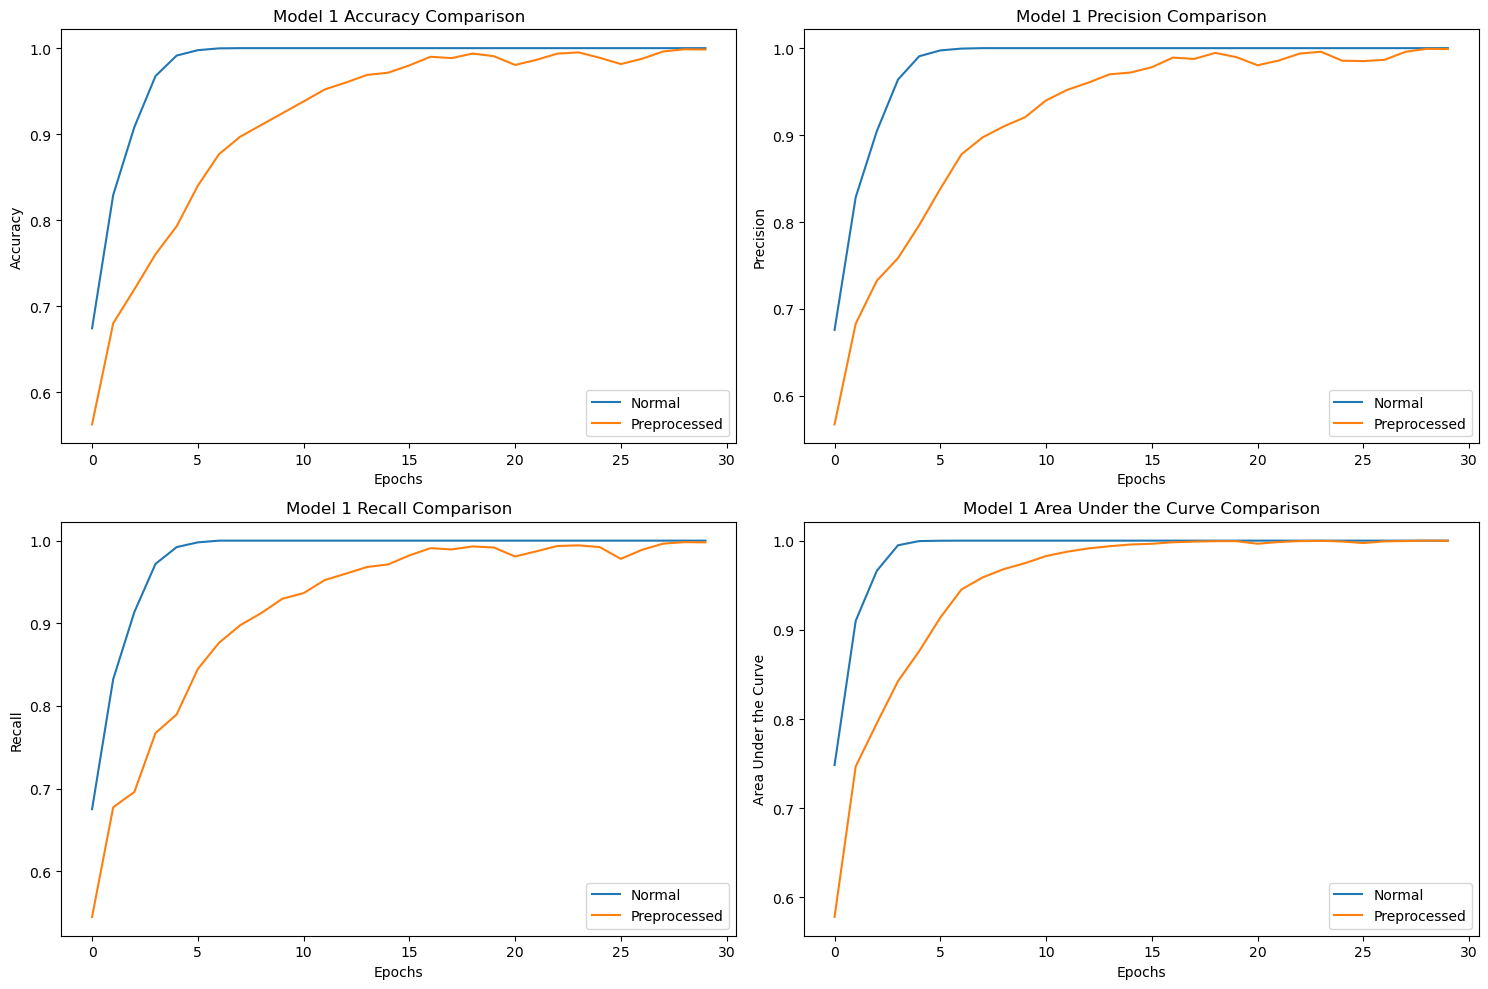

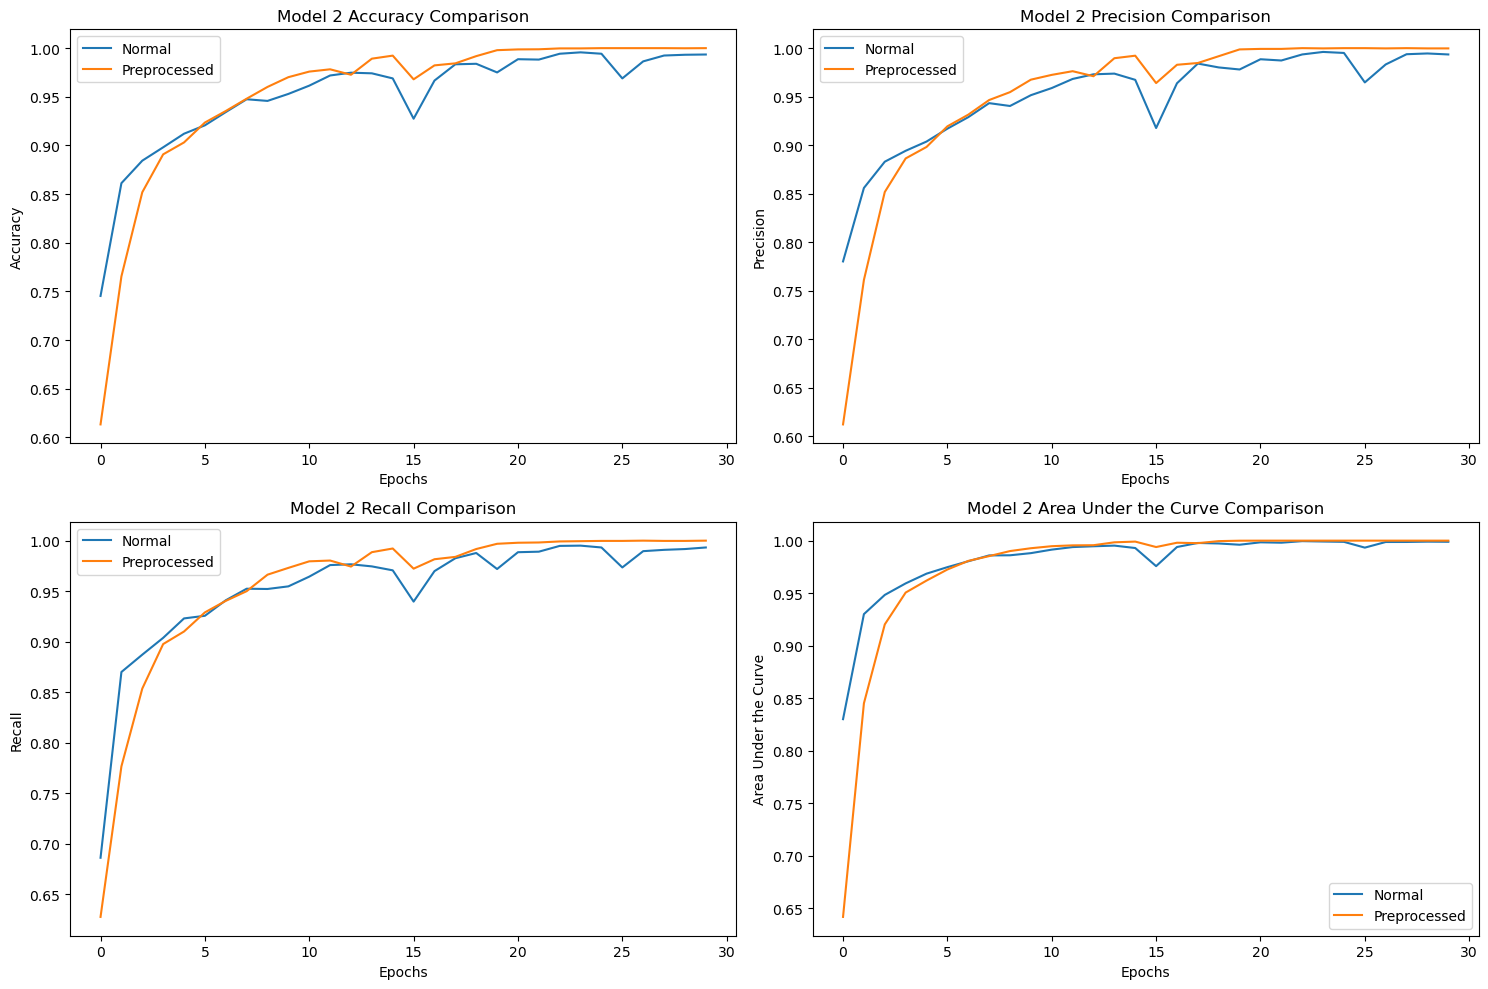

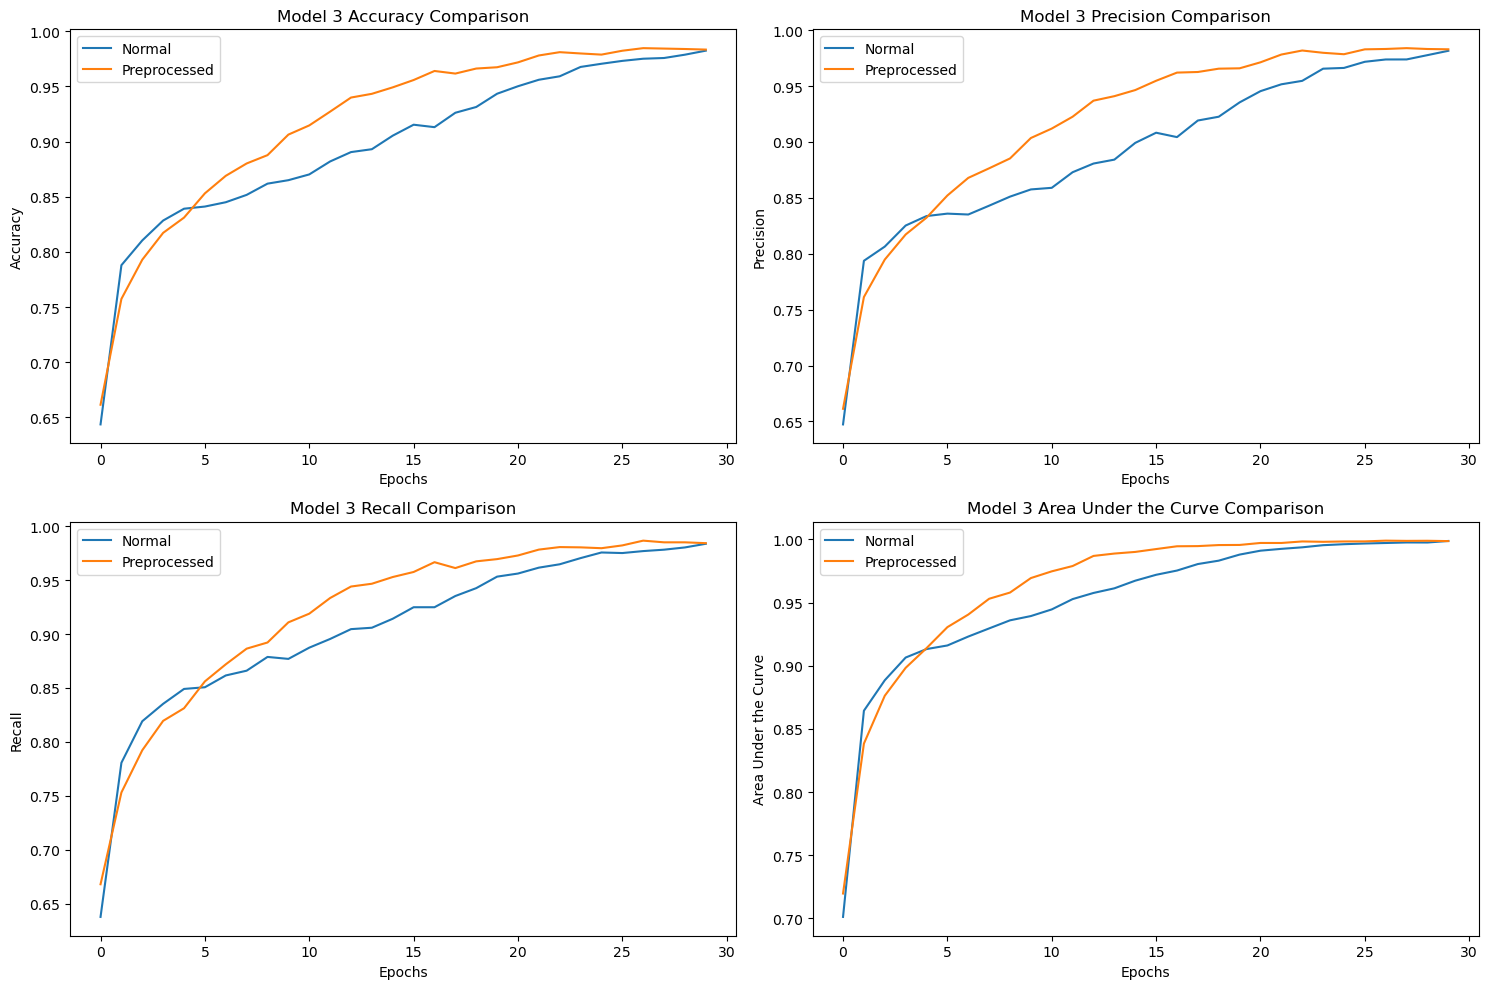

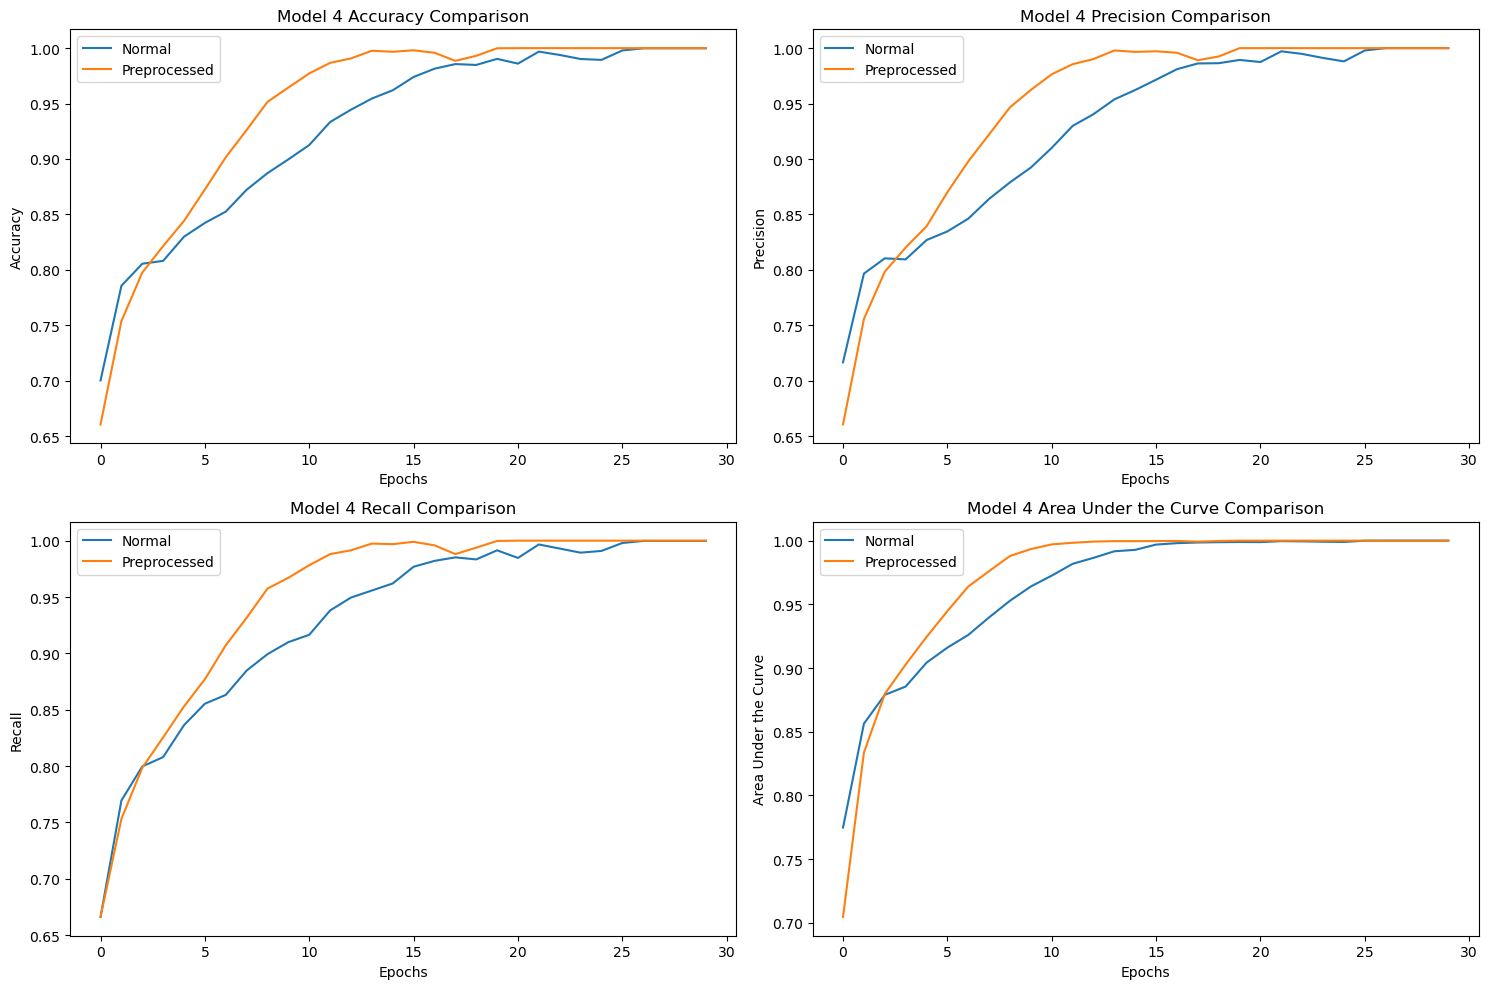

In [18]:
for j in range(4):
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(values[j][i], label='Normal')
        plt.plot(valuesP[j][i], label='Preprocessed')
        plt.title(f'Model {j+1} {metric} Comparison')
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
    plt.tight_layout()
    plt.show()

All the models seem to get to the same place by the end of the 30 epochs, but for models 2, 3, and 4, the preprocessed data performs better, sooner than the normal data. Model 1 is the only one where the normal data trains better with less epochs.